In [ ]:
# import libraries
import os
import sys
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

import tensorflow as tf
import keras
# from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import Precision, Recall, TruePositives
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%load_ext tensorboard

In [ ]:
# Copy the files from drive to current directory
base = Path('drive/My Drive/Colab Notebooks/')
ds_path = base/'fruits-360/'
sys.path.append(str(base))
# os.chdir(ds_path)
!pwd
!cp -r "{ds_path}" .

In [ ]:
base_dir = './fruits-360/'
train_dir = os.path.join(base_dir, 'Training', '')
test_dir = os.path.join(base_dir, 'Test', '')
print(train_dir)

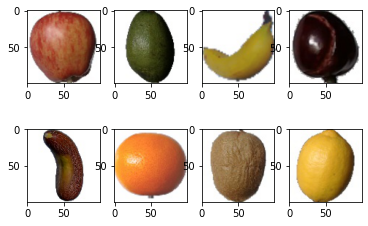

In [ ]:
fig, axs = plt.subplots(2,4)
axs[0,0].imshow(load_img(train_dir + "Apple Red 1/0_100.jpg"))    #492 imgs training
axs[0,1].imshow(load_img(train_dir + "Avocado/0_100.jpg"))        #427 imgs 
axs[0,2].imshow(load_img(train_dir + "Banana/0_100.jpg"))         #490 imgs
axs[0,3].imshow(load_img(train_dir + "Cherry 1/0_100.jpg"))       #492 imgs
axs[1,0].imshow(load_img(train_dir + "Cucumber Ripe/0_100.jpg"))  #392 imgs
axs[1,1].imshow(load_img(train_dir + "Grapefruit Pink/0_100.jpg"))#490 imgs
axs[1,2].imshow(load_img(train_dir + "Kiwi/0_100.jpg"))           #466 imgs
axs[1,3].imshow(load_img(train_dir + "Lemon/0_100.jpg"))          #492 imgs

In [ ]:
# Some hyper-parameters:
img_height = 100
img_width =  100  
input_shape = (img_height, img_width, 3) #resize the input images to this shape
batch_size  = 128        # Images per batch 
num_epochs  = 50       # Max number of training epochs

# Number of classes:
num_classes = 8

Fruits to be chosen for classification:

Apple Red 1, Avocado, Banana, Cherry 1, Cucumber Ripe, Grapefruit Pink, Kiwi, Lemon.

# 2. Convolutional Neural Network (CNN)

## a. Making and training a simple CNN

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               495744    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_ab", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_ab.h5'
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 7s 182ms/step - loss: 57.2524 - accuracy: 0.2840 - precision: 0.2902 - recall: 0.2717 - f1_score: 0.2889 - val_loss: 0.4652 - val_accuracy: 0.7734 - val_precision: 0.7767 - val_recall: 0.7719 - val_f1_score: 0.7743
Epoch 2/50
23/23 [==============================] - 3s 128ms/step - loss: 0.0933 - accuracy: 0.9621 - precision: 0.9684 - recall: 0.9597 - f1_score: 0.9643 - val_loss: 0.1278 - val_accuracy: 0.9359 - val_precision: 0.9359 - val_recall: 0.9359 - val_f1_score: 0.9359
Epoch 3/50
23/23 [==============================] - 3s 126ms/step - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9984 - val_precision: 0.9984 - val_recall: 0.9984 - val_f1_score: 0.9984
Epoch 4/50
23/23 [==============================] - 3s 127ms/step - loss: 2.3780e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9953

In [ ]:
%tensorboard --logdir logs/CNN_ab

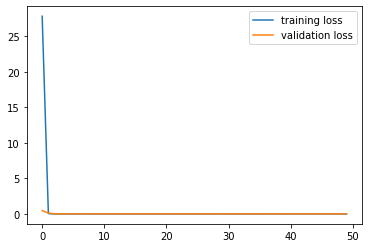

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

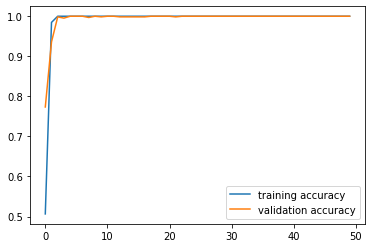

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_ab.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 111ms/step - loss: 0.0067 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - f1_score: 1.0000
Test loss:  0.005174145568162203
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

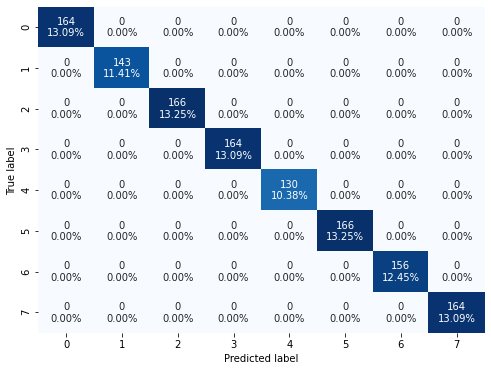

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## d. Adding Batch Normalization

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3872)             

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_d", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_d.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 5s 173ms/step - loss: 0.6120 - accuracy: 0.8598 - precision_2: 0.9276 - recall_2: 0.7569 - f1_score: 0.7914 - val_loss: 20.6293 - val_accuracy: 0.2297 - val_precision_2: 0.2297 - val_recall_2: 0.2297 - val_f1_score: 0.2297
Epoch 2/50
23/23 [==============================] - 3s 139ms/step - loss: 0.0055 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - f1_score: 1.0000 - val_loss: 6.6721 - val_accuracy: 0.4719 - val_precision_2: 0.4770 - val_recall_2: 0.4531 - val_f1_score: 0.4649
Epoch 3/50
23/23 [==============================] - 3s 139ms/step - loss: 0.0016 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - f1_score: 1.0000 - val_loss: 2.5516 - val_accuracy: 0.6875 - val_precision_2: 0.6887 - val_recall_2: 0.6844 - val_f1_score: 0.6865
Epoch 4/50
23/23 [==============================] - 3s 140ms/step - loss: 0.0011 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - f1_score: 1.0000 - val_loss: 0.878

In [ ]:
%tensorboard --logdir logs/CNN_d

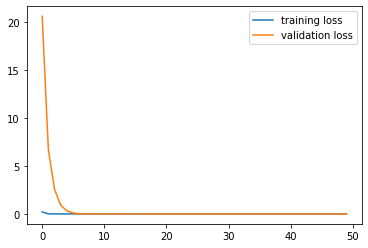

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

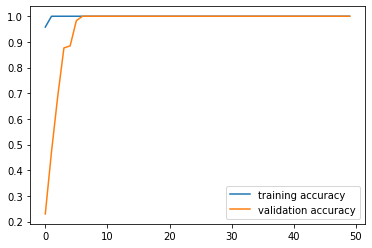

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_d.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 82ms/step - loss: 5.1184e-04 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - f1_score: 1.0000
Test loss:  0.00026533965137787163
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

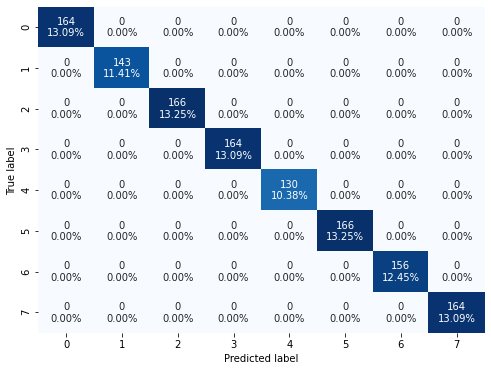

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## c. Experimenting with various CNNs

### 1st experiment: Removing 2nd conv layer







In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
# model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 69696)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8921216   
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_1.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 5s 164ms/step - loss: 0.5999 - accuracy: 0.8277 - precision_4: 0.8887 - recall_4: 0.7521 - f1_score: 0.7827 - val_loss: 9.2669 - val_accuracy: 0.5031 - val_precision_4: 0.5055 - val_recall_4: 0.5031 - val_f1_score: 0.5042
Epoch 2/50
23/23 [==============================] - 3s 133ms/step - loss: 0.0192 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - f1_score: 1.0000 - val_loss: 2.2481 - val_accuracy: 0.7234 - val_precision_4: 0.7246 - val_recall_4: 0.7234 - val_f1_score: 0.7240
Epoch 3/50
23/23 [==============================] - 3s 132ms/step - loss: 0.0066 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - f1_score: 1.0000 - val_loss: 0.7126 - val_accuracy: 0.7766 - val_precision_4: 0.7827 - val_recall_4: 0.7766 - val_f1_score: 0.7796
Epoch 4/50
23/23 [==============================] - 3s 131ms/step - loss: 0.0036 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - f1_score: 1.0000 - val_loss: 0.2918

In [ ]:
%tensorboard --logdir logs/CNN_c_1

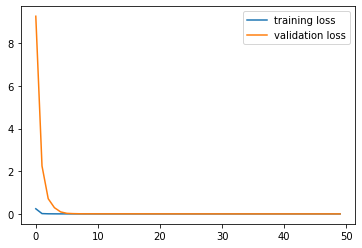

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

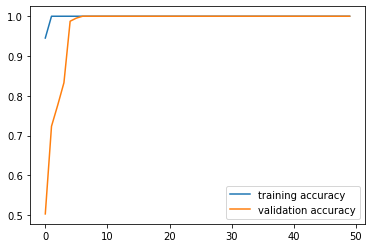

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_1.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 82ms/step - loss: 0.0017 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - f1_score: 1.0000
Test loss:  0.0008398331701755524
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

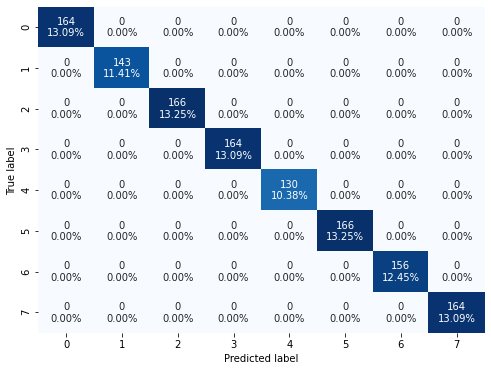

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 2nd experiment: Adding a 3rd conv layer

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 3rd convolution layer
model.add(Conv2D(16,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 16)       

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_2.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 5s 175ms/step - loss: 0.8423 - accuracy: 0.7507 - precision_6: 0.8708 - recall_6: 0.5803 - f1_score: 0.6505 - val_loss: 6.5297 - val_accuracy: 0.3766 - val_precision_6: 0.3772 - val_recall_6: 0.3766 - val_f1_score: 0.3769
Epoch 2/50
23/23 [==============================] - 3s 149ms/step - loss: 0.0165 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - f1_score: 1.0000 - val_loss: 3.8666 - val_accuracy: 0.4219 - val_precision_6: 0.4256 - val_recall_6: 0.4203 - val_f1_score: 0.4230
Epoch 3/50
23/23 [==============================] - 3s 141ms/step - loss: 0.0057 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - f1_score: 1.0000 - val_loss: 1.7961 - val_accuracy: 0.5250 - val_precision_6: 0.5736 - val_recall_6: 0.5234 - val_f1_score: 0.5477
Epoch 4/50
23/23 [==============================] - 3s 138ms/step - loss: 0.0034 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - f1_score: 1.0000 - val_loss: 0.7897

In [ ]:
%tensorboard --logdir logs/CNN_c_2

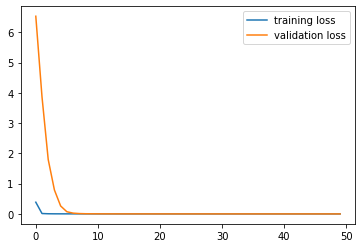

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

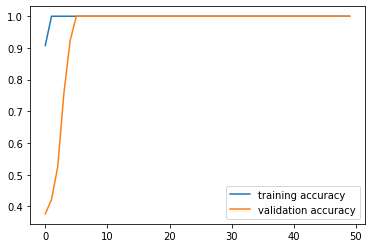

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_2.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 86ms/step - loss: 0.0015 - accuracy: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - f1_score: 1.0000
Test loss:  0.0007945537217892706
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

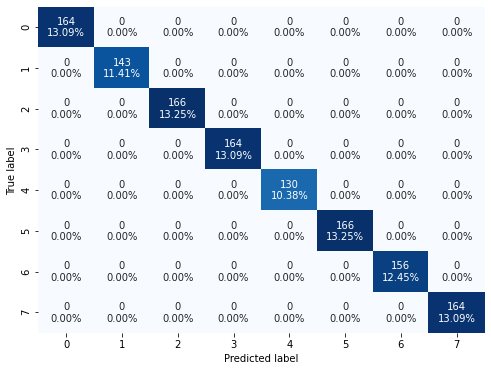

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3rd experiment: Adding more filters

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(256,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(128,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 256)     7168      
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 100, 256)     1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 33, 33, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 33, 128)       295040    
_________________________________________________________________
batch_normalization_10 (Batc (None, 33, 33, 128)       512       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15488)            

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_3.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 15s 528ms/step - loss: 0.5432 - accuracy: 0.8396 - precision_8: 0.9252 - recall_8: 0.8087 - f1_score: 0.8313 - val_loss: 68.4219 - val_accuracy: 0.2781 - val_precision_8: 0.2781 - val_recall_8: 0.2781 - val_f1_score: 0.2781
Epoch 2/50
23/23 [==============================] - 10s 443ms/step - loss: 0.0044 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - f1_score: 1.0000 - val_loss: 22.6491 - val_accuracy: 0.4703 - val_precision_8: 0.4703 - val_recall_8: 0.4703 - val_f1_score: 0.4703
Epoch 3/50
23/23 [==============================] - 10s 440ms/step - loss: 0.0017 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - f1_score: 1.0000 - val_loss: 9.3716 - val_accuracy: 0.4859 - val_precision_8: 0.4859 - val_recall_8: 0.4844 - val_f1_score: 0.4852
Epoch 4/50
23/23 [==============================] - 10s 442ms/step - loss: 0.0011 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - f1_score: 1.0000 - val_loss: 

In [ ]:
%tensorboard --logdir logs/CNN_c_3

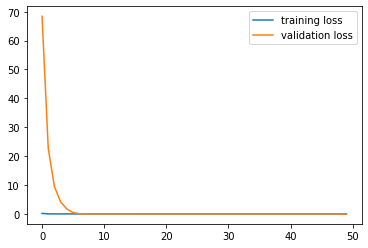

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

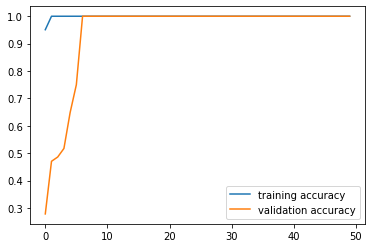

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_3.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 3s 236ms/step - loss: 1.7458e-04 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - f1_score: 1.0000
Test loss:  0.00010873997962335125
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

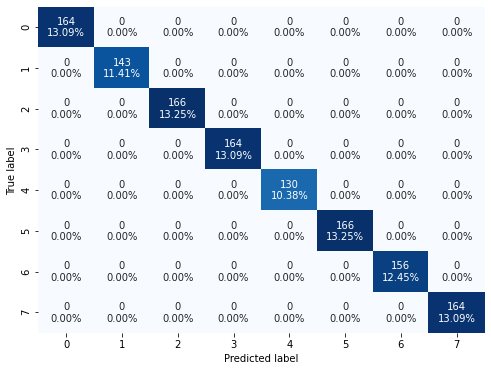

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4th experiment: Rescale = 1./255


In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_13 (Batc (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3872)             

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_4.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 5s 174ms/step - loss: 0.5387 - accuracy: 0.8225 - precision_10: 0.9092 - recall_10: 0.8022 - f1_score: 0.8206 - val_loss: 1.8390 - val_accuracy: 0.2594 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/50
23/23 [==============================] - 3s 140ms/step - loss: 0.0050 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - f1_score: 1.0000 - val_loss: 2.4358 - val_accuracy: 0.2016 - val_precision_10: 0.1822 - val_recall_10: 0.1312 - val_f1_score: 0.1523
Epoch 3/50
23/23 [==============================] - 3s 139ms/step - loss: 0.0020 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - f1_score: 1.0000 - val_loss: 3.2232 - val_accuracy: 0.2516 - val_precision_10: 0.2696 - val_recall_10: 0.2359 - val_f1_score: 0.2517
Epoch 4/50
23/23 [==============================] - 4s 153ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - f1_score:

In [ ]:
%tensorboard --logdir logs/CNN_c_4

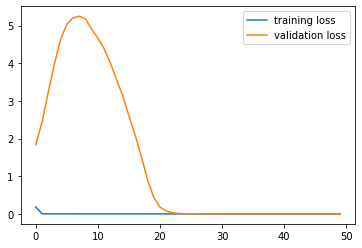

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

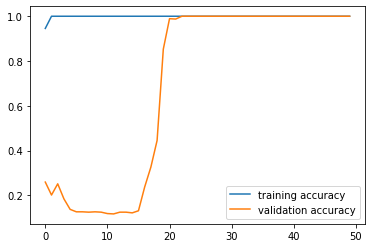

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_4.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 90ms/step - loss: 0.0019 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - f1_score: 1.0000
Test loss:  0.0009041246376000345
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

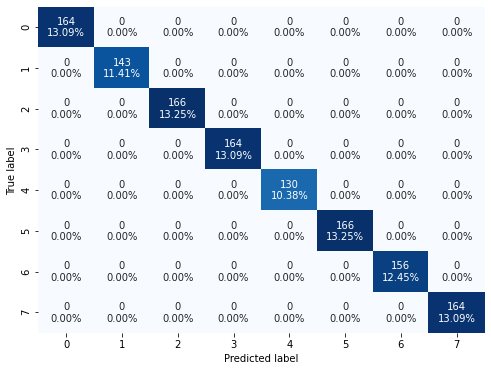

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 5th experiment: moving relu after Batch Normalization

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_16 (Batc (None, 33, 33, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 33, 33, 32)       

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_5", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_5.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 6s 191ms/step - loss: 0.5334 - accuracy: 0.8451 - precision_12: 0.9555 - recall_12: 0.7868 - f1_score: 0.8165 - val_loss: 15.5271 - val_accuracy: 0.1312 - val_precision_12: 0.1312 - val_recall_12: 0.1312 - val_f1_score: 0.1312
Epoch 2/50
23/23 [==============================] - 4s 151ms/step - loss: 0.0074 - accuracy: 1.0000 - precision_12: 1.0000 - recall_12: 1.0000 - f1_score: 1.0000 - val_loss: 6.6147 - val_accuracy: 0.3047 - val_precision_12: 0.3081 - val_recall_12: 0.3047 - val_f1_score: 0.3063
Epoch 3/50
23/23 [==============================] - 3s 150ms/step - loss: 0.0038 - accuracy: 1.0000 - precision_12: 1.0000 - recall_12: 1.0000 - f1_score: 1.0000 - val_loss: 2.9741 - val_accuracy: 0.4422 - val_precision_12: 0.4512 - val_recall_12: 0.4187 - val_f1_score: 0.4343
Epoch 4/50
23/23 [==============================] - 4s 152ms/step - loss: 0.0028 - accuracy: 1.0000 - precision_12: 1.0000 - recall_12: 1.0000 - f1_score: 1.0000 - v

In [ ]:
%tensorboard --logdir logs/CNN_c_5

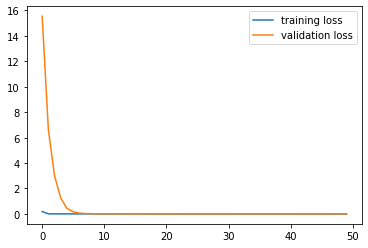

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

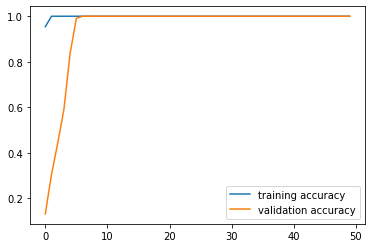

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_5.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 102ms/step - loss: 4.0014e-04 - accuracy: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - f1_score: 1.0000
Test loss:  0.00022388497018255293
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

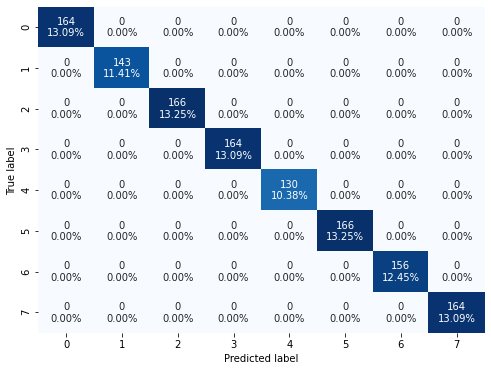

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6th experiment: Adding a 2nd FC layer

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_6", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_6.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 6s 176ms/step - loss: 0.5973 - accuracy: 0.8158 - precision_14: 0.9290 - recall_14: 0.7353 - f1_score: 0.7801 - val_loss: 7.4715 - val_accuracy: 0.4453 - val_precision_14: 0.4436 - val_recall_14: 0.4422 - val_f1_score: 0.4429
Epoch 2/50
23/23 [==============================] - 3s 139ms/step - loss: 0.0050 - accuracy: 1.0000 - precision_14: 1.0000 - recall_14: 1.0000 - f1_score: 1.0000 - val_loss: 3.8722 - val_accuracy: 0.6016 - val_precision_14: 0.6065 - val_recall_14: 0.5828 - val_f1_score: 0.5941
Epoch 3/50
23/23 [==============================] - 3s 138ms/step - loss: 0.0021 - accuracy: 1.0000 - precision_14: 1.0000 - recall_14: 1.0000 - f1_score: 1.0000 - val_loss: 2.0893 - val_accuracy: 0.6141 - val_precision_14: 0.6784 - val_recall_14: 0.6000 - val_f1_score: 0.6367
Epoch 4/50
23/23 [==============================] - 3s 135ms/step - loss: 0.0014 - accuracy: 1.0000 - precision_14: 1.0000 - recall_14: 1.0000 - f1_score: 1.0000 - va

In [ ]:
%tensorboard --logdir logs/CNN_c_6

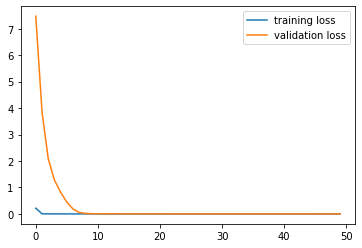

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

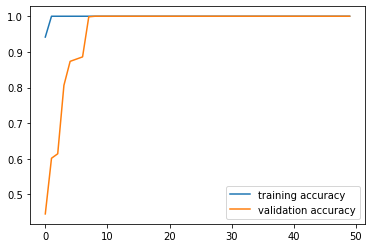

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_6.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 84ms/step - loss: 1.0492e-04 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000 - f1_score: 1.0000
Test loss:  8.136143151205033e-05
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

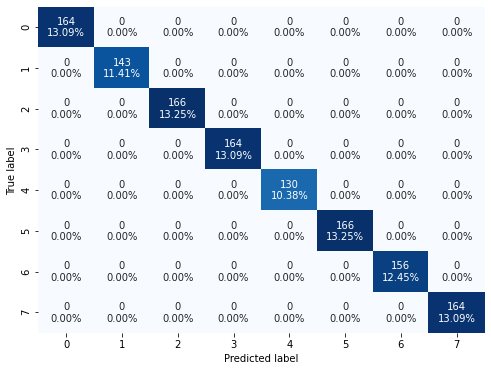

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 7th experiment: Adding Dropout

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100, 64)      0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
dropout_4 (Dropout)          (None, 33, 33, 32)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 33, 33, 32)      

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_7", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_7.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 7s 224ms/step - loss: 0.6907 - accuracy: 0.7997 - precision_20: 0.8986 - recall_20: 0.7474 - f1_score: 0.7744 - val_loss: 4.8537 - val_accuracy: 0.4953 - val_precision_20: 0.4984 - val_recall_20: 0.4875 - val_f1_score: 0.4928
Epoch 2/50
23/23 [==============================] - 4s 187ms/step - loss: 0.0127 - accuracy: 1.0000 - precision_20: 1.0000 - recall_20: 1.0000 - f1_score: 1.0000 - val_loss: 1.4381 - val_accuracy: 0.7797 - val_precision_20: 0.7980 - val_recall_20: 0.7656 - val_f1_score: 0.7815
Epoch 3/50
23/23 [==============================] - 4s 187ms/step - loss: 0.0060 - accuracy: 1.0000 - precision_20: 1.0000 - recall_20: 1.0000 - f1_score: 1.0000 - val_loss: 0.3804 - val_accuracy: 0.8656 - val_precision_20: 0.8670 - val_recall_20: 0.8656 - val_f1_score: 0.8663
Epoch 4/50
23/23 [==============================] - 4s 188ms/step - loss: 0.0039 - accuracy: 1.0000 - precision_20: 1.0000 - recall_20: 1.0000 - f1_score: 1.0000 - va

In [ ]:
%tensorboard --logdir logs/CNN_c_7

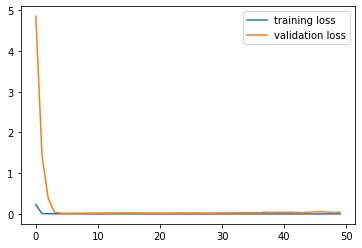

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

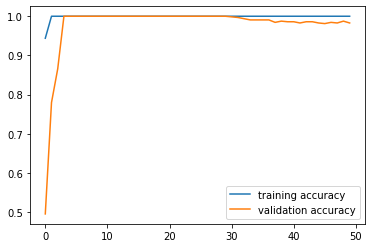

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_7.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 72ms/step - loss: 0.0176 - accuracy: 1.0000 - precision_21: 1.0000 - recall_21: 1.0000 - f1_score: 1.0000
Test loss:  0.01582602597773075
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

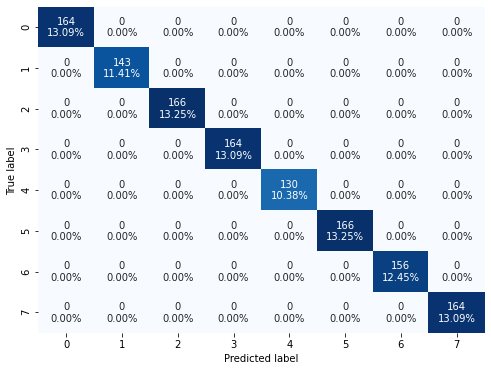

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 8th experiment: Applying various augmentations

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_24 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_25 (Batc (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3872)             

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2,
                               horizontal_flip=True,
                               rotation_range=90)

train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_8", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_8.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 13s 526ms/step - loss: 0.7342 - accuracy: 0.7854 - precision_18: 0.8831 - recall_18: 0.7169 - f1_score: 0.7576 - val_loss: 18.8873 - val_accuracy: 0.2094 - val_precision_18: 0.2094 - val_recall_18: 0.2094 - val_f1_score: 0.2094
Epoch 2/50
23/23 [==============================] - 11s 483ms/step - loss: 0.0097 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000 - f1_score: 1.0000 - val_loss: 7.0560 - val_accuracy: 0.3703 - val_precision_18: 0.3715 - val_recall_18: 0.3703 - val_f1_score: 0.3709
Epoch 3/50
23/23 [==============================] - 11s 489ms/step - loss: 0.0048 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000 - f1_score: 1.0000 - val_loss: 2.9367 - val_accuracy: 0.5359 - val_precision_18: 0.5349 - val_recall_18: 0.5266 - val_f1_score: 0.5307
Epoch 4/50
23/23 [==============================] - 11s 492ms/step - loss: 0.0098 - accuracy: 0.9981 - precision_18: 0.9981 - recall_18: 0.9981 - f1_score: 0.9969

In [ ]:
%tensorboard --logdir logs/CNN_c_8

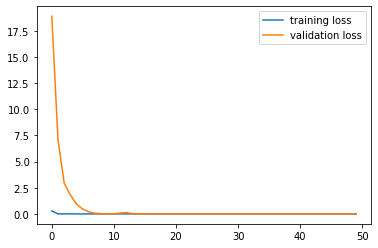

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

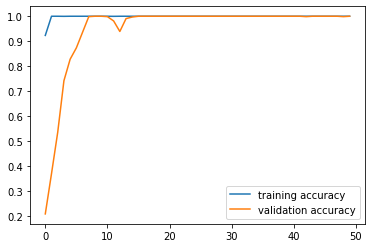

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_8.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 77ms/step - loss: 3.1296e-04 - accuracy: 1.0000 - precision_23: 1.0000 - recall_23: 1.0000 - f1_score: 1.0000
Test loss:  0.0004155128262937069
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Final: Mixing 4th, 6th, 7th and 8th experiment

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_39 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_40 (Batc (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 3872)            

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2, 
                               rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=90)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_c_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_c_9.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 14s 534ms/step - loss: 0.9401 - accuracy: 0.7180 - precision_30: 0.8248 - recall_30: 0.6206 - f1_score: 0.6749 - val_loss: 2.2537 - val_accuracy: 0.1406 - val_precision_30: 0.2027 - val_recall_30: 0.1406 - val_f1_score: 0.1661
Epoch 2/50
23/23 [==============================] - 11s 481ms/step - loss: 0.0409 - accuracy: 0.9971 - precision_30: 0.9980 - recall_30: 0.9956 - f1_score: 0.9969 - val_loss: 2.4067 - val_accuracy: 0.1359 - val_precision_30: 0.2000 - val_recall_30: 0.1359 - val_f1_score: 0.1615
Epoch 3/50
23/23 [==============================] - 11s 486ms/step - loss: 0.0171 - accuracy: 0.9986 - precision_30: 0.9998 - recall_30: 0.9986 - f1_score: 0.9992 - val_loss: 2.6087 - val_accuracy: 0.2531 - val_precision_30: 0.3398 - val_recall_30: 0.2453 - val_f1_score: 0.2848
Epoch 4/50
23/23 [==============================] - 11s 480ms/step - loss: 0.0130 - accuracy: 0.9992 - precision_30: 0.9992 - recall_30: 0.9988 - f1_score: 0.9990 

In [ ]:
%tensorboard --logdir logs/CNN_c_9

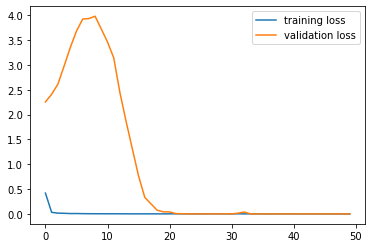

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

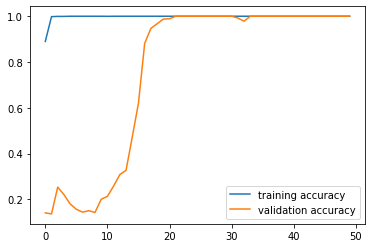

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_c_9.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 4s 338ms/step - loss: 8.0581e-05 - accuracy: 1.0000 - precision_31: 1.0000 - recall_31: 1.0000 - f1_score: 1.0000
Test loss:  9.232849697582424e-05
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

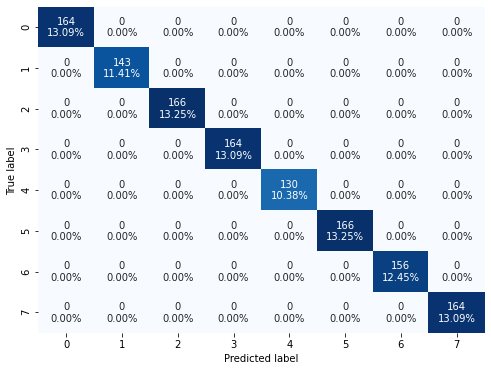

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## e. Testing CNN without FC layer and then without pooling layers

### Without fc layer

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_30 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
batch_normalization_31 (Batc (None, 33, 33, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3872)            

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_e_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_e_1.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 5s 166ms/step - loss: 1.3102 - accuracy: 0.7049 - precision_24: 0.7635 - recall_24: 0.6652 - f1_score: 0.6930 - val_loss: 15.5775 - val_accuracy: 0.1266 - val_precision_24: 0.1266 - val_recall_24: 0.1266 - val_f1_score: 0.1266
Epoch 2/50
23/23 [==============================] - 3s 131ms/step - loss: 0.0033 - accuracy: 0.9995 - precision_24: 0.9995 - recall_24: 0.9995 - f1_score: 0.9988 - val_loss: 5.2287 - val_accuracy: 0.3797 - val_precision_24: 0.3797 - val_recall_24: 0.3797 - val_f1_score: 0.3797
Epoch 3/50
23/23 [==============================] - 3s 133ms/step - loss: 8.1213e-04 - accuracy: 1.0000 - precision_24: 1.0000 - recall_24: 1.0000 - f1_score: 1.0000 - val_loss: 1.7119 - val_accuracy: 0.7406 - val_precision_24: 0.7504 - val_recall_24: 0.7375 - val_f1_score: 0.7439
Epoch 4/50
23/23 [==============================] - 3s 132ms/step - loss: 5.7415e-04 - accuracy: 1.0000 - precision_24: 1.0000 - recall_24: 1.0000 - f1_score: 1.

In [ ]:
%tensorboard --logdir logs/CNN_e_1

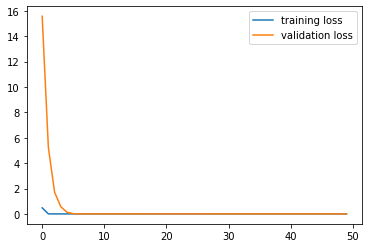

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

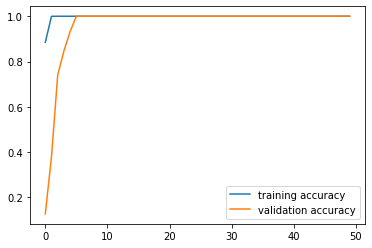

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_e_1.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 79ms/step - loss: 7.8617e-04 - accuracy: 1.0000 - precision_25: 1.0000 - recall_25: 1.0000 - f1_score: 1.0000
Test loss:  0.0016479674959555268
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

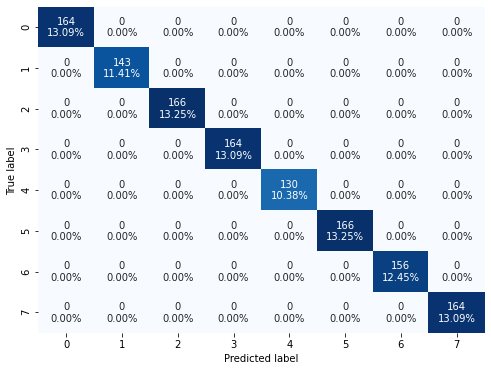

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Without pooling layers

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3,3)))

# 2nd convolution layer
model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_32 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 100, 100, 32)      18464     
_________________________________________________________________
batch_normalization_33 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
flatten_12 (Flatten)         (None, 320000)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               40960128  
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)             

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

In [ ]:
generator = ImageDataGenerator(validation_split=0.2)
train_generator = generator.flow_from_directory(train_dir, 
                                 target_size = (img_height,img_width),       
                                 batch_size=batch_size,
                                 subset='training',
                                 shuffle=True)                          
val_generator = generator.flow_from_directory(train_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                subset='validation')

test_generator = generator.flow_from_directory(test_dir,
                                target_size = (img_height,img_width),                   
                                batch_size=batch_size,
                                shuffle=False)

Found 2995 images belonging to 8 classes.
Found 746 images belonging to 8 classes.
Found 1253 images belonging to 8 classes.


In [ ]:
logdir = os.path.join("./logs/CNN_e_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [ ]:
#save best model
filepath = 'models/CNN_e_2.h5'
callbacks = [ModelCheckpoint(os.path.join(base_dir,filepath), monitor = 'val_loss', save_best_only=True),
             tensorboard_callback] 

#Train model
hist = model.fit(train_generator, 
                    steps_per_epoch=train_generator.samples//batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples//batch_size,
                    callbacks=callbacks) 

Epoch 1/50
23/23 [==============================] - 7s 317ms/step - loss: 0.0097 - accuracy: 1.0000 - precision_26: 1.0000 - recall_26: 1.0000 - f1_score: 1.0000 - val_loss: 58.1021 - val_accuracy: 0.2578 - val_precision_26: 0.2578 - val_recall_26: 0.2578 - val_f1_score: 0.2578
Epoch 2/50
23/23 [==============================] - 7s 309ms/step - loss: 0.0037 - accuracy: 1.0000 - precision_26: 1.0000 - recall_26: 1.0000 - f1_score: 1.0000 - val_loss: 45.3075 - val_accuracy: 0.2734 - val_precision_26: 0.2734 - val_recall_26: 0.2734 - val_f1_score: 0.2734
Epoch 3/50
23/23 [==============================] - 7s 308ms/step - loss: 0.0018 - accuracy: 1.0000 - precision_26: 1.0000 - recall_26: 1.0000 - f1_score: 1.0000 - val_loss: 27.7212 - val_accuracy: 0.2766 - val_precision_26: 0.2766 - val_recall_26: 0.2766 - val_f1_score: 0.2766
Epoch 4/50
23/23 [==============================] - 7s 305ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_26: 1.0000 - recall_26: 1.0000 - f1_score: 1.0000 -

In [ ]:
%tensorboard --logdir logs/CNN_e_2

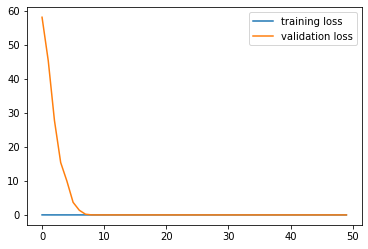

In [ ]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

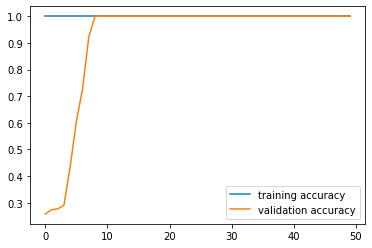

In [ ]:
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

In [ ]:
model = load_model('fruits-360/models/CNN_e_2.h5', custom_objects={'f1_score': f1_score})

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall(), f1_score])

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print('Test loss: ', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

10/10 [==============================] - 2s 133ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_27: 1.0000 - recall_27: 1.0000 - f1_score: 1.0000
Test loss:  0.0006425991887226701
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test f1_score: 1.0


Text(0.5, 33.0, 'Predicted label')

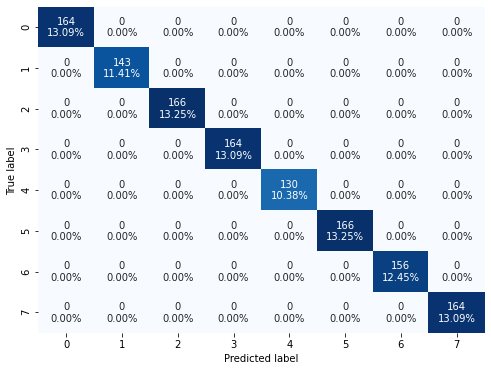

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator,
                            steps = np.ceil(test_generator.samples/batch_size)
                            )
y_pred = np.argmax(predictions, axis=-1)
y_test = test_generator.labels

cf_matrix = confusion_matrix(y_test, y_pred)

#Prepare visuals
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(8,8)

# MAKE THE HEATMAP VISUALIZATION
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')